## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.special import gamma, factorial

**The Simulation of $Le'vy-Chentsov$ Karlin Stable processes has two parts, the small-jump part and large-jump part**

### Small-jump part
This part contains five functions:
1. rho(c0, c2, x, y, beta)
   - Input:
      - c0, c2: constants from intrinsic embedding formulas
      - x, y: two points on $R^2$
      - beta: $\beta \in (0, 1)$
   - Output:
      - cov: covariance from intrinsic embedding method

2. R2_fft(n, beta)
   - Input:
      - n: $n^2$ is the number of points in the simulation
      - beta: $\beta \in (0, 1)$
   - Output:
      - c0: constant in intrinsic embedding method
      - c2: constant in intrinsic embedding method
      - S_tilde: 1-dim FFT of circulant matrix construct from the covariance function of fBm

3. LC_complex_rv(n)
   - Input:
      - n: $n^2$ is the number of points in the simulation
   - Output:
      - x: a complex standard normal matrix with size $n\times n$
      
4. LC_small_t(n, t1, t2)
   - Input:
      - n: $n^2$ is the number of points in the simulation
      - t1: a regular lattice on horizontal axis over $[0, 1/\sqrt{2}]$
      - t2: a regular lattice on vertical axis over $[0, 1/\sqrt{2}]$
   - Output:
      - t: a matrix $t$ with size $n\times n$ for intrinsic embedding 
      
5. LC_fBm(n, H)
   - Input:
      - n: $n^2$ is the number of points in the simulation
      - alpha: $\alpha \in (0, 2)$
      - H: Hurst parameter $H \in (0, 0.5)$
   - Output: 
      - fractional Levy Brwonian field on $[0, 1]\times[0, 1]$

### Large-jump part:
This part contains two functions:
1. LC_one_oov(n, beta)
   - Input:
      - n: $n**2$ is the number of points on unit disk $[0, 1]\times[0, 1]$
      - beta: $\beta \in (0, 1)$ 
    - Output:
      - one copy of odd-occupancy vector from location method
      
2. LC_large_jump(n, alpha, beta)
   - Input:
      - n: $n**2$ is the number of points on unit disk $[0, 1]\times[0, 1]$
      - alpha: $\alpha \in (0, 2)$
      - beta: $\beta \in (0, 1)$ 
   - Output:
      - Y2: the large-jump part

**Once the simulations of small-jump part and large-jump part completed separately, we combine them to obtain the $L\'evy-Chentsov$ Karlin stable processes and produce some plots**     
1. LC_KSP(n, alpha, beta)
   - Input:
      - n: $n**2$ is the number of points on unit disk $[0, 1]\times[0, 1]$
      - alpha: $\alpha \in (0, 2)$
      - beta: $\beta \in (0, 1)$ 
   - Output:
      - Y1: small-jump part
      - Y2: large-jump part
      - Y: combined of small and large jumps

In [2]:
def rho(c0, c2, x, y, H):
    h = np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    cov = c0 + c2*h**2 - h**(2*H)
    return cov

def R2_fft(n, H):
    t1, t2 = np.linspace(0, 1/np.sqrt(2), n+1), np.linspace(0, 1/np.sqrt(2), n+1)
    c2 = H
    c0 = 1 - c2
    cov = np.zeros((n+1, n+1))
    for i in range(0, n+1):
        for j in range(0, n+1):
            cov[j, i] = rho(c0, c2, [t1[i], t2[j]], [t1[0], t2[0]], H)
    s, S = np.zeros((2*n, 2*n)), np.zeros((2*n, 2*n))
    s[0:(n+1),:] = np.c_[cov[:,0:n], cov[:,n], cov[:,n-1:0:-1]]
    S = np.r_[s[0:n,:], s[n,:].reshape(1, 2*n), s[n-1:0:-1,:]]
    S_tilde = np.fft.fft2(S)
    return c0, c2, S_tilde

def LC_complex_rv(n):
    x_1, x_2 = np.random.multivariate_normal(np.zeros(2*n), np.diag(np.ones(2*n)), 2*n), np.random.multivariate_normal(np.zeros(2*n), np.diag(np.ones(2*n)), 2*n)
    x = np.zeros((2*n, 2*n), dtype=np.complex)
    for i in range(0, 2*n):
        for j in range(0, 2*n):
            x[i, j] = np.complex(x_1[i,j], x_2[i,j])
    return x

def LC_small_t(n, t1, t2):
    z1, z2 = np.random.normal(0, 1, 1), np.random.normal(0, 1, 1)
    t = np.zeros((n+1, n+1))
    for i in range(0, n+1):
        for j in range(0, n+1):
            t[i,j] = t1[i]*z1 + t2[j]*z2
    return t

def LC_fBm(n, H):
    t1, t2 = np.linspace(0, 1/np.sqrt(2), n+1), np.linspace(0, 1/np.sqrt(2), n+1)
    c0, c2, S_tilde = R2_fft(n, H)
    x = LC_complex_rv(n)
    y = np.fft.fft2(np.sqrt(S_tilde)*x)
    y1_tilde = (1/(2*n))*y.real[0:n+1,0:n+1]
    y1 = np.zeros((n+1, n+1))
    t = LC_small_t(n, t1, t2)
    y1 = y1_tilde - y1_tilde[0,0] + np.sqrt(2*c2)*t
    return np.sqrt(2**((beta/2)-1))*y1

def LC_one_oov(n, beta, flattened = False):
    ga_1, ga_beta, ga_1beta = np.random.gamma(1, 1, 1), np.random.gamma(beta, 1, 1), np.random.gamma(1-beta, 1, 1)
    Lambda = ga_1*ga_1beta/ga_beta
    Q_beta = 1 + np.random.poisson(Lambda, 1)
    if (beta <= 0.5):
        Q_beta[Q_beta > 10000] = 10000
    t1, t2 = np.linspace(0, 1, n+1), np.linspace(0, 1, n+1)
    #t1, t2 = np.linspace(0, 1/np.sqrt(2), n+1), np.linspace(0, 1/np.sqrt(2), n+1)
    t_1, t_2 = np.meshgrid(t1, t2)
    #t_1, t_2 = t_1.flatten(), t_2.flatten()
    r = np.random.uniform(0, np.sqrt(2), int((3/4)*Q_beta))
    #theta = np.random.uniform(0, 2*np.pi, Q_beta)
    theta = np.random.uniform(-np.pi/2, np.pi, int((3/4)*Q_beta))
    s_pos = np.c_[np.cos(theta), np.sin(theta)]
    count = np.zeros((n+1, n+1))
    for i in range(0, int((3/4)*Q_beta)):
        event = np.where(r[i] < s_pos[i,0]*t_1+s_pos[i,1]*t_2, 1, 0)
        count += event
    if flattened == False:
        return count % 2
    else:
        return (count % 2).flatten()

def LC_large_jump(N, n, alpha, beta, epsilon):    
    D = np.zeros(((n+1)**2, N))
    for i in range(0, N):
        D[:, i] = LC_one_oov(n, beta, flattened = True)
    
    U = np.random.uniform(0, 1, N)
    V = np.random.choice([-1, 1], N, replace=True, p=[0.5, 0.5])*(epsilon/(U**(1/alpha)))   
    y2 = np.sum(D*V, axis=1)
    return y2.reshape(n+1, n+1)

def LC_KSP(n, alpha, beta):
    if alpha == 1:
        C_alpha = np.pi/2
    else:
        C_alpha = (1-alpha)/(gamma(2-alpha)*np.cos(np.pi*alpha/2))
    if alpha >= 1:
        epsilon = (0.01*(3-alpha)*np.sqrt(alpha*C_alpha)/(2-alpha)**(3/2))**(2/alpha)     # error from B-E < 0.01
    else:
        epsilon = 0.0001
    sigma_epsilon = (np.sqrt(alpha*C_alpha/(2-alpha))**(1/2))*epsilon**(1-alpha/2)
    nu_epsilon = 2**(1-beta)*(np.sqrt(2)*2*np.pi)**(beta)*C_alpha*epsilon**(-alpha)
    N = int(np.random.poisson(nu_epsilon, 1))  
    
    Y1 = sigma_epsilon*LC_fBm(n, beta/2)
    Y2 = LC_large_jump(N, n, alpha, beta, epsilon=epsilon)
    Y = Y1 + Y2       
    return Y1, Y2, Y

## Plots

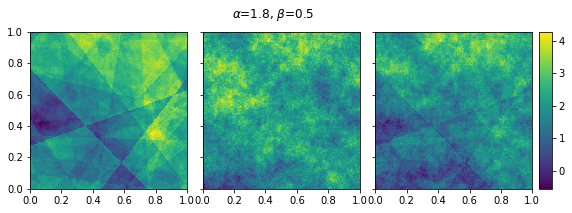

In [33]:
import matplotlib.pyplot as plt

n = 300
alpha = 1.8
beta = 0.5

Y1, Y2, Y = LC_KSP(n, alpha, beta)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.1)
axs[0].imshow(Y2, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[1].imshow(Y1, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im = axs[2].imshow(Y, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
plt.colorbar(im, cax=cax) 

fig.suptitle(r"$\alpha$=" + str(alpha) + r", $\beta$=" + str(beta))
plt.savefig('fLC_alpha'+str(alpha)+'_beta'+str(beta)+'.pdf', bbox_inches = 'tight')

plt.show()


## Four plots

In [15]:
n = 300
alpha = 1.2
beta = 0.5

Y11, Y21, Y1 = LC_KSP(n, alpha, beta)

In [16]:
n = 300
alpha = 1.2
beta = 0.8

Y12, Y22, Y2 = LC_KSP(n, alpha, beta)

In [17]:
n = 300
alpha = 1.8
beta = 0.5

Y13, Y23, Y3 = LC_KSP(n, alpha, beta)

In [18]:
n = 300
alpha = 1.8
beta = 0.8

Y14, Y24, Y4 = LC_KSP(n, alpha, beta)

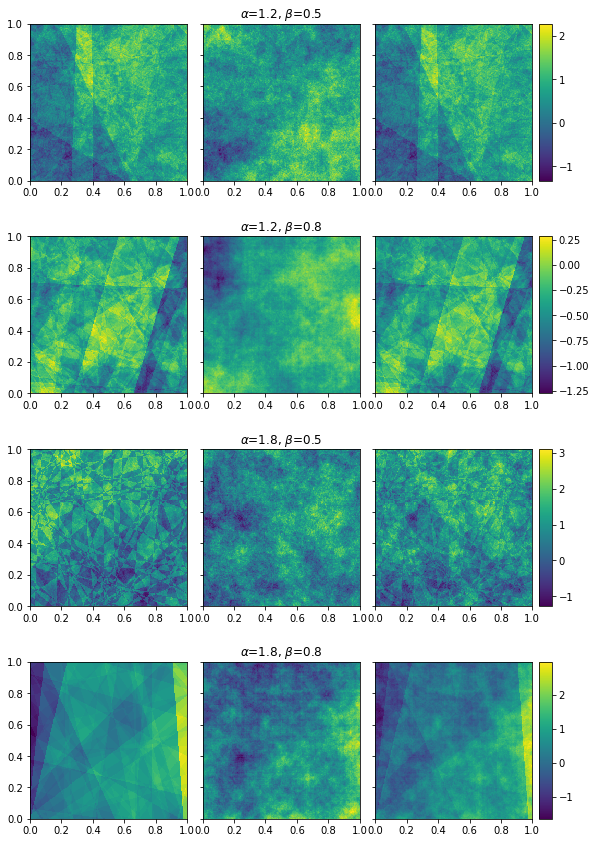

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 3, figsize=(9, 15), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.1)
axs[0,0].imshow(Y21, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[0,1].imshow(Y11, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im1 = axs[0,2].imshow(Y1, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax1 = fig.add_axes([axs[0,2].get_position().x1+0.01,axs[0,2].get_position().y0,0.02,axs[0,2].get_position().height])
plt.colorbar(im1, cax=cax1) 

axs[1,0].imshow(Y22, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[1,1].imshow(Y12, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im2 = axs[1,2].imshow(Y2, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax2 = fig.add_axes([axs[1,2].get_position().x1+0.01,axs[1,2].get_position().y0,0.02,axs[1,2].get_position().height])
plt.colorbar(im2, cax=cax2) 

axs[2,0].imshow(Y23, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[2,1].imshow(Y13, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im3 = axs[2,2].imshow(Y3, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax3 = fig.add_axes([axs[2,2].get_position().x1+0.01,axs[2,2].get_position().y0,0.02,axs[2,2].get_position().height])
plt.colorbar(im3, cax=cax3) 

axs[3,0].imshow(Y24, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[3,1].imshow(Y14, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im4 = axs[3,2].imshow(Y4, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax4 = fig.add_axes([axs[3,2].get_position().x1+0.01,axs[3,2].get_position().y0,0.02,axs[3,2].get_position().height])
plt.colorbar(im4, cax=cax4) 

axs[0,1].set_title(r"$\alpha$=1.2" + r", $\beta$=0.5")
axs[1,1].set_title(r"$\alpha$=1.2" + r", $\beta$=0.8")
axs[2,1].set_title(r"$\alpha$=1.8" + r", $\beta$=0.5")
axs[3,1].set_title(r"$\alpha$=1.8" + r", $\beta$=0.8")

plt.savefig('Figure8.pdf', bbox_inches = 'tight')


plt.show()

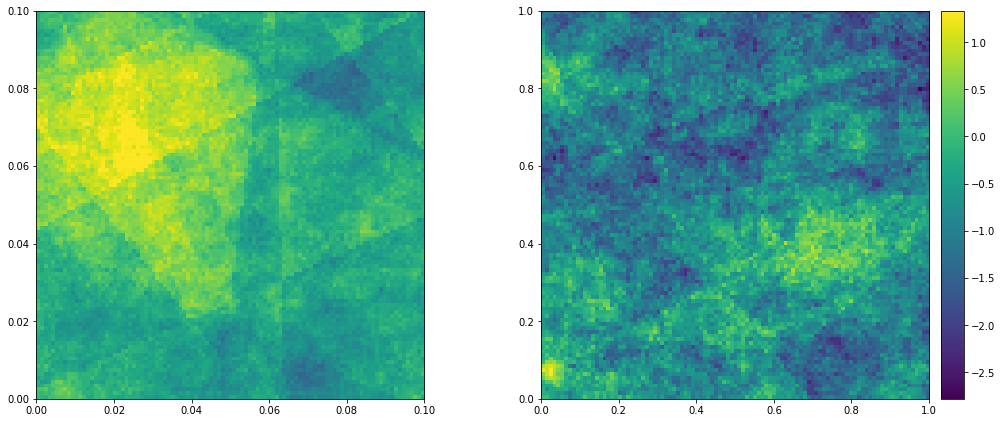

In [45]:
n = 1000
alpha = 1.8
beta = 0.5

Y1, Y2, Y = LC_KSP(n=1000, alpha=alpha, beta=beta)

Y_1 = Y[0:101, 0:101]

Y_2 = np.zeros((101,101))
for i in range(0, 101):
    for j in range(0, 101):
        k1 = 10*i
        k2 = 10*j
        Y_2[i,j] = Y[k1,k2]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharey=False)

plt.subplots_adjust(wspace = 0.3)
im1 = axs[0].imshow(Y_1, cmap='viridis', interpolation='nearest', origin='lower', vmin=np.min(Y_2), vmax=np.max(Y_2), extent = [0,0.1,0,0.1])
axs[0].set_ylim(bottom = 0, top = 0.1)
axs[0].set_xlim(left = 0, right = 0.1)


im2 = axs[1].imshow(Y_2, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[1].set_ylim(bottom = 0, top = 1)
axs[1].set_xlim(left = 0, right = 1)
cax2 = fig.add_axes([axs[1].get_position().x1+0.01,axs[1].get_position().y0,0.02,axs[1].get_position().height])
plt.colorbar(im2,cax=cax2)

#fig.suptitle(r"$\alpha$=" + str(alpha) + r", $\beta$=" + str(beta))
plt.savefig('levyfs.pdf', bbox_inches = 'tight')


plt.show()

In [42]:
beta = 0.5
M = 5000
n = 10 
s = [0.2, 0.3]
t = [0.2, 0.8]

X = 0
for i in range(M):
    D = LC_fBm(n, beta/2)
    X = X + D[2,3] * D[2,9]

cov = 0.5*(np.sqrt(s[0]**2+s[1]**2)**beta + np.sqrt(t[0]**2+t[1]**2)**beta - np.sqrt((s[0]-t[0])**2+(s[1]-t[1])**2)**beta)

print(X/M,cov)

0.3986094730034192 0.4007210827127537


In [43]:
def two_end_pts(r,theta,R):
    ## x = R, -R
    y1 = r/np.sin(theta) - 1/np.tan(theta)*R
    y2 = r/np.sin(theta) - 1/np.tan(theta)*(-R)
    ## y = R, -R
    x1 = (r/np.sin(theta)-R)*np.tan(theta)
    x2 = (r/np.sin(theta)+R)*np.tan(theta)
    
    X = np.array([R,-R,x1,x2])
    Y = np.array([y1,y2,R,-R])
    
    ind = np.where(X**2+Y**2<= 2* R**2)
    return X[ind],Y[ind]

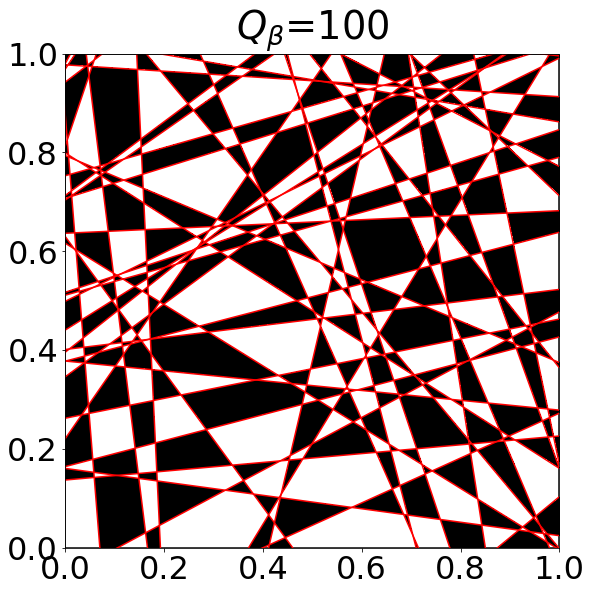

In [44]:
n = 1000
Q = 100

## should be b/w 0 and 1 instead of 0 and 1/np.sqrt(2)
t1, t2 = np.linspace(0, 1, n+1), np.linspace(0, 1, n+1)
t_1, t_2 = np.meshgrid(t1, t2)
#t_1, t_2 = t_1.flatten(), t_2.flatten()
## radius is b/w 0 and sqrt 2
r = np.random.uniform(0, np.sqrt(2), Q)
theta = np.random.uniform(0, 2*np.pi, Q)

s_pos = np.c_[np.cos(theta), np.sin(theta)]
count = np.zeros((n+1, n+1))
for i in range(0, Q):
    event = np.where(r[i] < s_pos[i,0]*t_1+s_pos[i,1]*t_2, 1, 0)
    count += event

count = count % 2
plt.figure(figsize = (9, 9))
plt.rc('font', size=32)
im = plt.imshow(1-count, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
R = np.sqrt(2)
plt.ylim(bottom = 0,top = 1)
plt.xlim(left = 0, right = 1)
## add a color bar
##plt.colorbar(im) 
    
    
plt.plot((0,0),(0,1),color = 'black')
plt.plot((0,1),(1,1),color = 'black')
plt.plot((1,1),(1,0),color = 'black')
plt.plot((1,0),(0,0),color = 'black')
for i in range(0,Q):
    X,Y = two_end_pts(r[i],theta[i],R)
    plt.plot(X,Y,color = 'red', linewidth = 1.5)
        
plt.title(r"$Q_\beta$="+str(Q))
plt.tight_layout()
#plt.savefig('fLC_OOV_Q'+str(Q)+'.pdf')
plt.show()



